# Model Zoo
> Base TTS Model test code for LatentForce VoiceStudio

## 0. Common Code

In [ ]:
import torch
from transformers import AutoTokenizer, AutoProcessor

from voicestudio.utils.audio_utils import show_waveform

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("INFO: Using device -", device)

## 1. Parler TTS

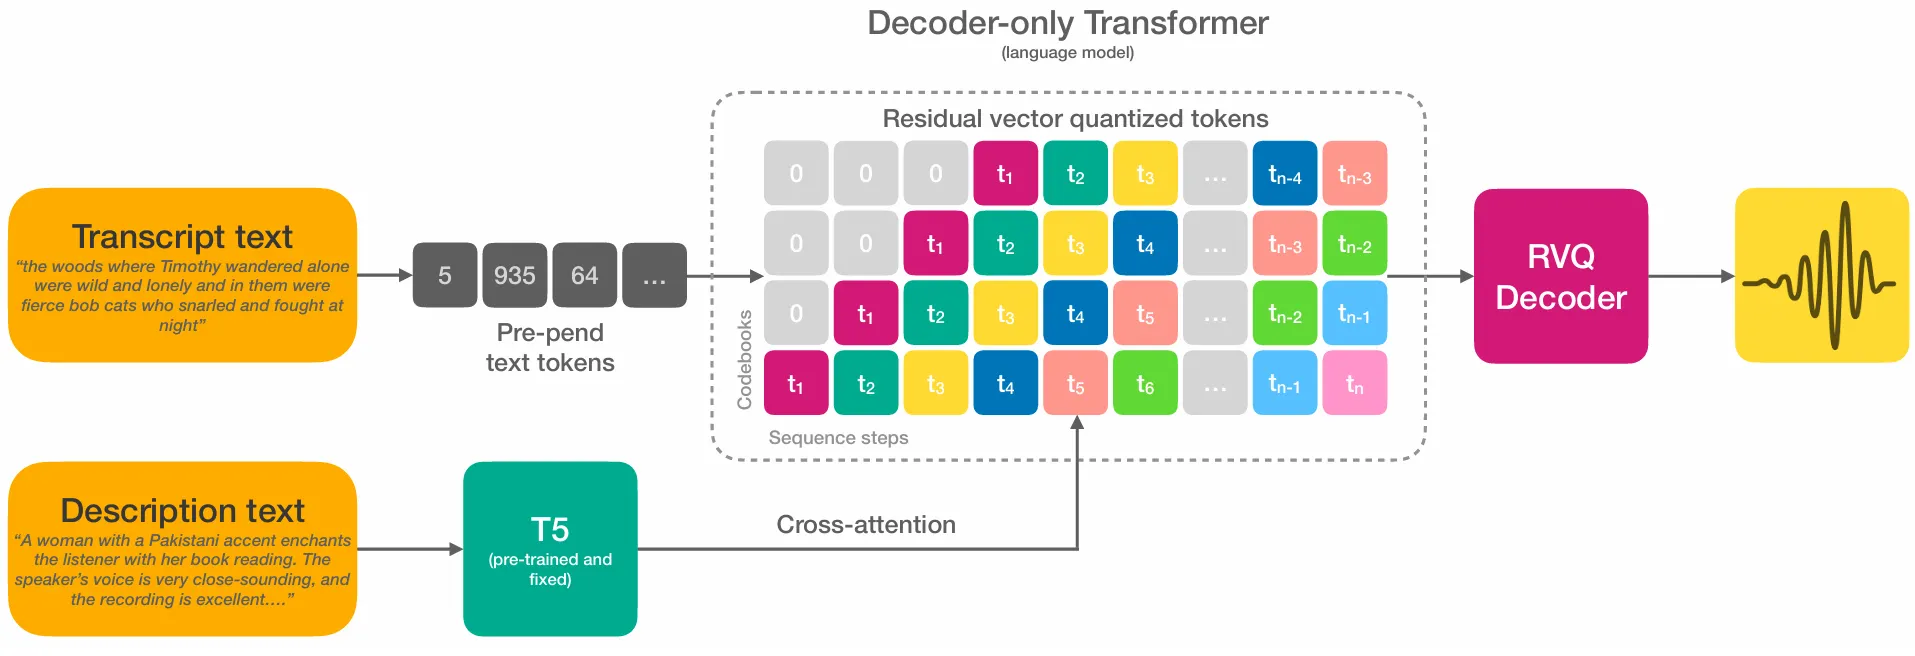

In [ ]:
from voicestudio.models.parler_tts import ParlerTTSForConditionalGeneration

In [ ]:
model_id = "parler-tts/parler-tts-mini-v1"
#model_id = "parler-tts/parler-tts-large-v1"
#model_id = "parler-tts/parler-tts-mini-v1.1"

model = ParlerTTSForConditionalGeneration.from_pretrained(model_id).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [ ]:
prompt = "Hey, how are you doing today?"
#description = "Jon's voice is monotone yet slightly fast in delivery, with a very close recording that almost has no background noise."
description = "A female speaker delivers a slightly expressive and animated speech with a moderate speed and pitch. The recording is of very high quality, with the speaker's voice sounding clear and very close up."

input_ids = tokenizer(description, return_tensors="pt").input_ids.to(device)
prompt_input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

audio_values = model.generate(input_ids=input_ids, prompt_input_ids=prompt_input_ids)
show_waveform(None, waveform=audio_values.cpu().squeeze(), sr=model.config.sampling_rate)

## 2. Higgs Audio (v2)

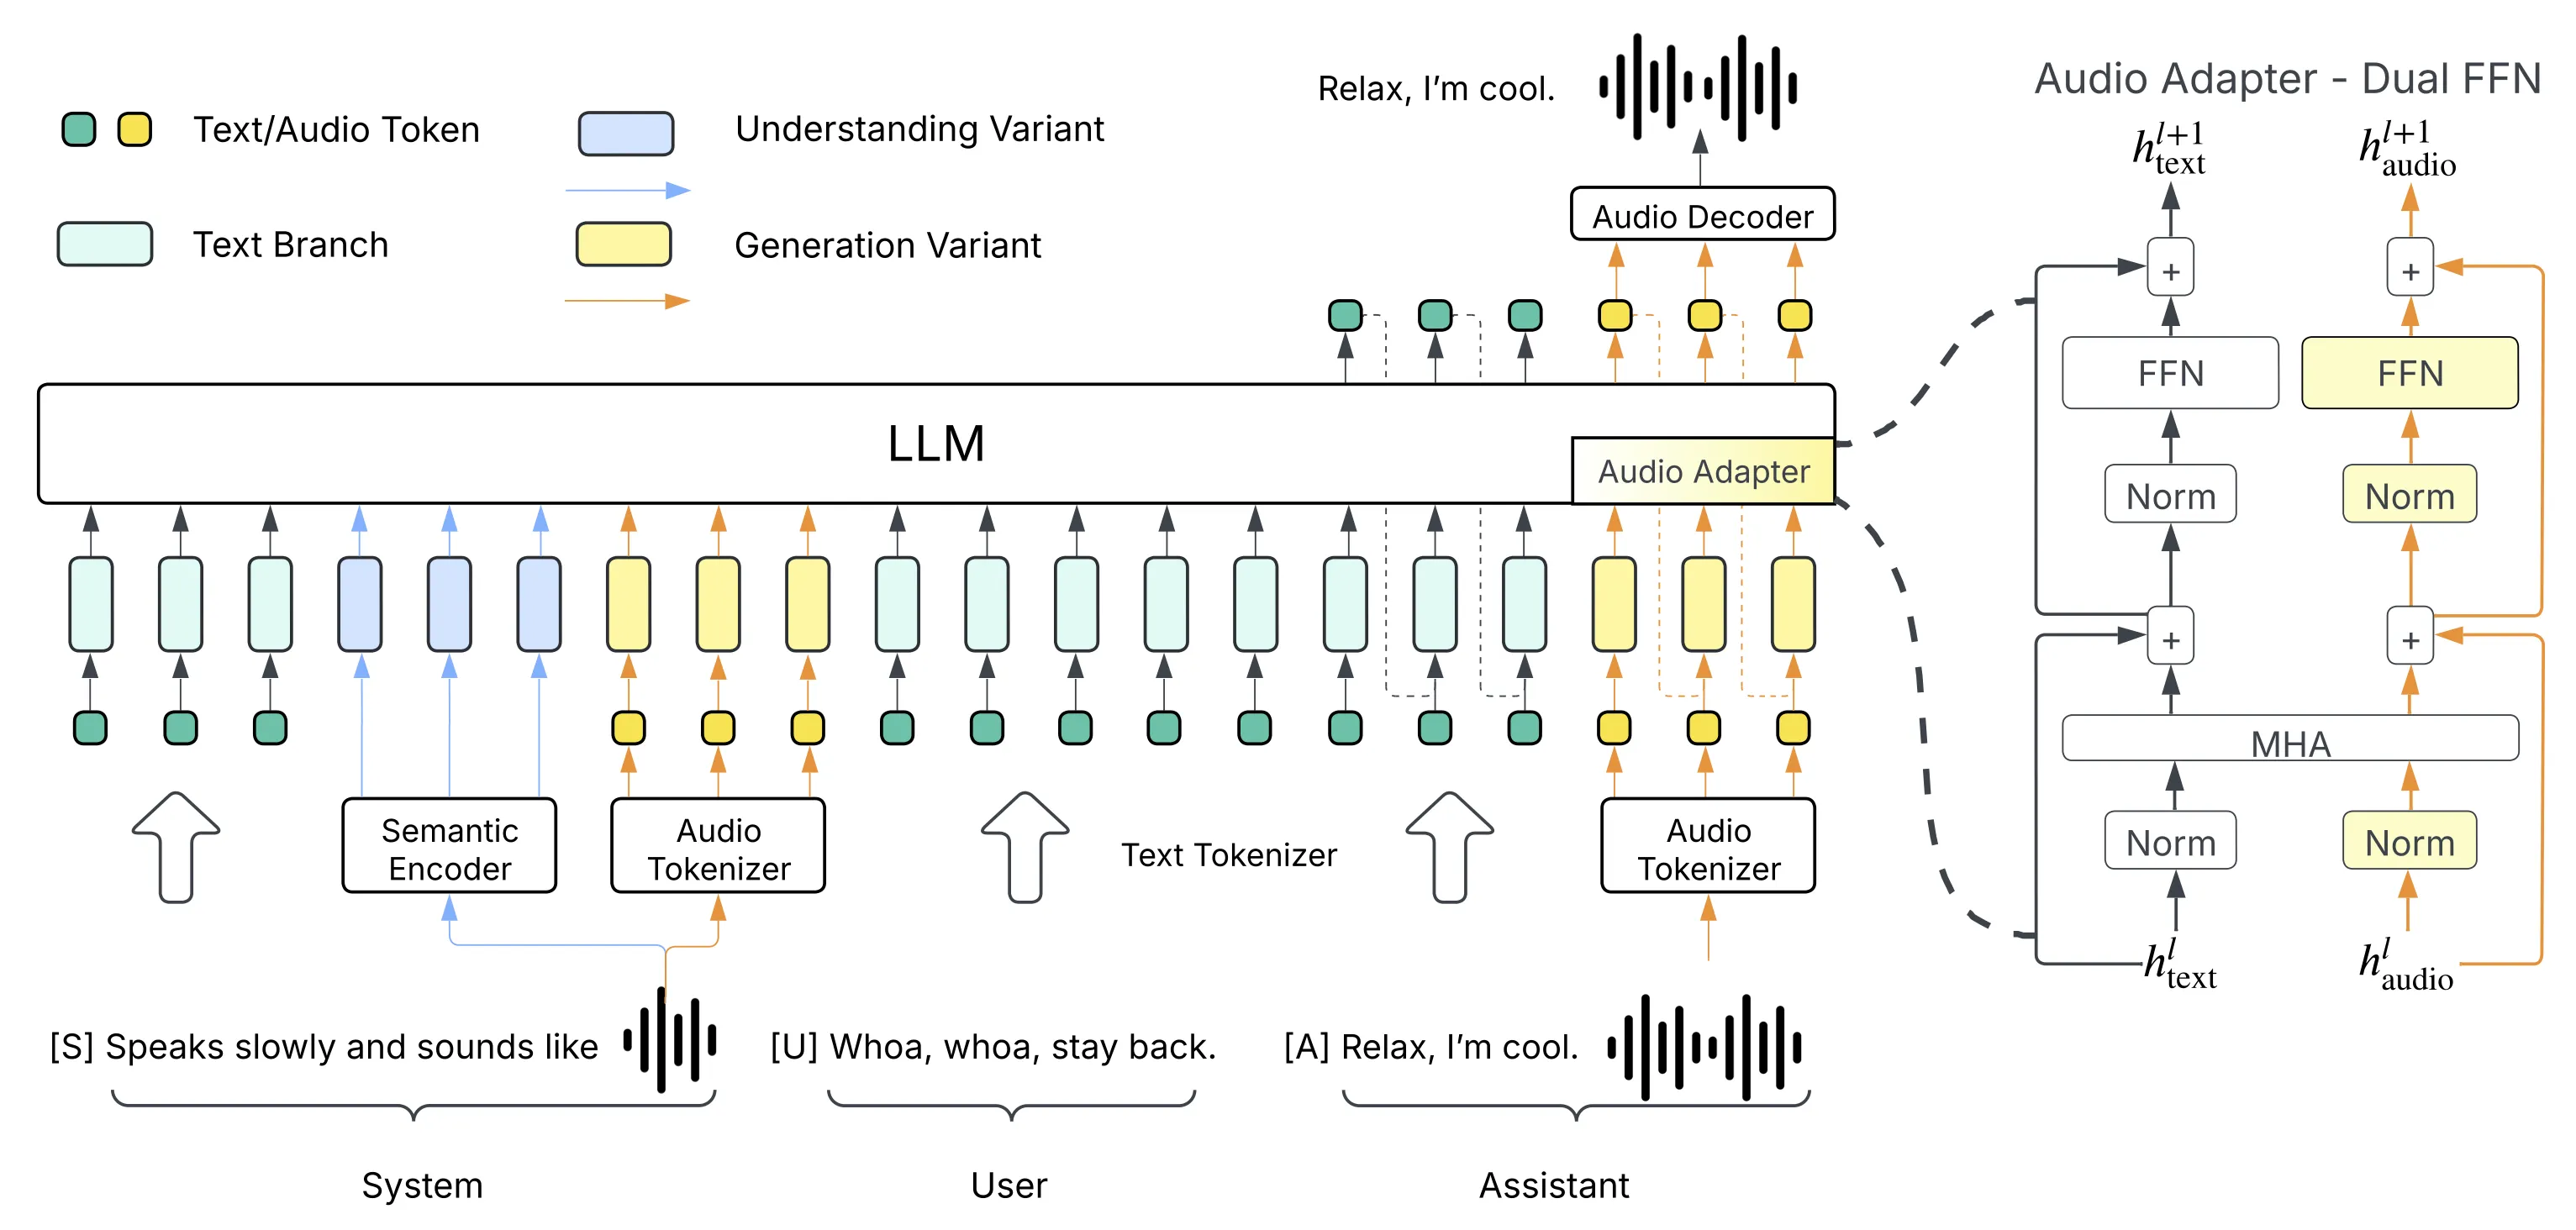

In [ ]:
from boson_multimodal.serve.serve_engine import HiggsAudioServeEngine, HiggsAudioResponse
from boson_multimodal.data_types import ChatMLSample, Message, AudioContent

import torch
import torchaudio
import time
import click

MODEL_PATH = "bosonai/higgs-audio-v2-generation-3B-base"
AUDIO_TOKENIZER_PATH = "bosonai/higgs-audio-v2-tokenizer"

system_prompt = (
    "Generate audio following instruction.\n\n<|scene_desc_start|>\nAudio is recorded from a quiet room.\n<|scene_desc_end|>"
)

messages = [
    Message(
        role="system",
        content=system_prompt,
    ),
    Message(
        role="user",
        content="The sun rises in the east and sets in the west. This simple fact has been observed by humans for thousands of years.",
    ),
]
device = "cuda" if torch.cuda.is_available() else "cpu"

serve_engine = HiggsAudioServeEngine(MODEL_PATH, AUDIO_TOKENIZER_PATH, device=device)

output: HiggsAudioResponse = serve_engine.generate(
    chat_ml_sample=ChatMLSample(messages=messages),
    max_new_tokens=1024,
    temperature=0.3,
    top_p=0.95,
    top_k=50,
    stop_strings=["<|end_of_text|>", "<|eot_id|>"],
)
torchaudio.save(f"output.wav", torch.from_numpy(output.audio)[None, :], output.sampling_rate)

In [ ]:
from voicestudio.boson_multimodal.serve.serve_engine import HiggsAudioServeEngine, HiggsAudioResponse
from voicestudio.boson_multimodal.data_types import ChatMLSample, Message
import torch
import torchaudio

MODEL_PATH = "bosonai/higgs-audio-v2-generation-3B-base"
AUDIO_TOKENIZER_PATH = "bosonai/higgs-audio-v2-tokenizer"

system_prompt = (
    "Generate audio following instruction.\n\n<|scene_desc_start|>\nAudio is recorded from a quiet room.\n<|scene_desc_end|>"
)

messages = [
    Message(role="system", content=system_prompt),
    Message(role="user", content="The sun rises in the east and sets in the west."),
]

device = "cuda" if torch.cuda.is_available() else "cpu"

# OLD: Use HiggsAudioServeEngine
serve_engine = HiggsAudioServeEngine(MODEL_PATH, AUDIO_TOKENIZER_PATH, device=device)

output: HiggsAudioResponse = serve_engine.generate(
    chat_ml_sample=ChatMLSample(messages=messages),
    max_new_tokens=1024,
    temperature=0.3,
    top_p=0.95,
    top_k=50,
    stop_strings=["<|end_of_text|>", "<|eot_id|>"],
)

torchaudio.save(f"output.wav", torch.from_numpy(output.audio)[None, :], output.sampling_rate)

In [ ]:
from voicestudio.boson_multimodal.model.higgs_audio import (
    HiggsAudioForConditionalGeneration,
    HiggsAudioProcessor
)
from voicestudio.boson_multimodal.data_types import ChatMLSample, Message
import torch
import torchaudio

MODEL_PATH = "bosonai/higgs-audio-v2-generation-3B-base"
AUDIO_TOKENIZER_PATH = "bosonai/higgs-audio-v2-tokenizer"

system_prompt = (
    "Generate audio following instruction.\n\n<|scene_desc_start|>\nAudio is recorded from a quiet room.\n<|scene_desc_end|>"
)

messages = [
    Message(role="system", content=system_prompt),
    Message(role="user", content="The sun rises in the east and sets in the west."),
]

device = "cuda" if torch.cuda.is_available() else "cpu"

# NEW: Load model and processor separately
model = HiggsAudioForConditionalGeneration.from_pretrained(
    MODEL_PATH,
    torch_dtype="auto"
).to(device)

# Set audio tokenizer
model.set_audio_tokenizer(AUDIO_TOKENIZER_PATH, device=device)

# Optional: Prepare KV caches for optimization
model.prepare_kv_caches()
if device == "cuda":
    model.enable_cuda_graphs()

# Load processor
processor = HiggsAudioProcessor.from_pretrained(
    MODEL_PATH,
    audio_tokenizer_path=AUDIO_TOKENIZER_PATH,
    device=device
)

# Process inputs
inputs = processor(ChatMLSample(messages=messages))

# Move to device
for k, v in inputs.items():
    if isinstance(v, torch.Tensor):
        inputs[k] = v.to(device)

# Generate
output = model.generate(
    **inputs,
    max_new_tokens=1024,
    temperature=0.3,
    top_p=0.95,
    top_k=50,
    return_audio_waveforms=True,  # Automatically decode audio
)

torchaudio.save("output.wav", torch.from_numpy(output.audio_waveforms)[None, :], output.sampling_rate)

In [ ]:
from voicestudio.boson_multimodal.model.higgs_audio import (
    HiggsAudioForConditionalGeneration,
    HiggsAudioProcessor
)
import torch
import torchaudio

MODEL_PATH = "bosonai/higgs-audio-v2-generation-3B-base"
AUDIO_TOKENIZER_PATH = "bosonai/higgs-audio-v2-tokenizer"

# System prompt
system_prompt = (
    "Generate audio following instruction.\n\n"
    "<|scene_desc_start|>\n"
    "Audio is recorded from a quiet room.\n"
    "<|scene_desc_end|>"
)

# Standard Transformers messages format (list of dicts)
messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": "The sun rises in the east and sets in the west. "
                                "This simple fact has been observed by humans for thousands of years."},
]

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load model
model = HiggsAudioForConditionalGeneration.from_pretrained(
    MODEL_PATH,
    dtype="auto"
).to(device)

# Set audio tokenizer
model.set_audio_tokenizer(AUDIO_TOKENIZER_PATH, device=device)

# Optionally prepare KV caches and enable CUDA graphs for optimization
model.prepare_kv_caches()
if device == "cuda":
    model.enable_cuda_graphs()

# Load processor
processor = HiggsAudioProcessor.from_pretrained(
    MODEL_PATH,
    audio_tokenizer_path=AUDIO_TOKENIZER_PATH,
    device=device
)

# Process inputs using standard messages format
batch_input = processor(messages)

# Move to device (HiggsAudioBatchInput has attributes, not dict keys)
batch_input.input_ids = batch_input.input_ids.to(device)
batch_input.attention_mask = batch_input.attention_mask.to(device)
if batch_input.audio_features is not None:
    batch_input.audio_features = batch_input.audio_features.to(device)
if batch_input.audio_feature_attention_mask is not None:
    batch_input.audio_feature_attention_mask = batch_input.audio_feature_attention_mask.to(device)
if batch_input.audio_in_ids is not None:
    batch_input.audio_in_ids = batch_input.audio_in_ids.to(device)
if batch_input.audio_in_ids_start is not None:
    batch_input.audio_in_ids_start = batch_input.audio_in_ids_start.to(device)
if batch_input.audio_out_ids is not None:
    batch_input.audio_out_ids = batch_input.audio_out_ids.to(device)
if batch_input.audio_out_ids_start is not None:
    batch_input.audio_out_ids_start = batch_input.audio_out_ids_start.to(device)

# Generate (convert dataclass to kwargs)
from dataclasses import asdict
output = model.generate(
    **asdict(batch_input),
    max_new_tokens=1024,
    temperature=0.3,
    top_p=0.95,
    top_k=50,
    return_audio_waveforms=True,
)

# Save audio
torchaudio.save(
    "output.wav",
    torch.from_numpy(output.audio_waveforms)[None, :],
    output.sampling_rate
)

print("Audio saved to output.wav")

In [ ]:
MODEL_PATH = "bosonai/higgs-audio-v2-generation-3B-base"
AUDIO_TOKENIZER_PATH = "bosonai/higgs-audio-v2-tokenizer"

# System prompt
system_prompt = (
    "Generate audio following instruction.\n\n"
    "<|scene_desc_start|>\n"
    "Audio is recorded from a quiet room.\n"
    "<|scene_desc_end|>"
)

# Standard Transformers messages format (list of dicts)
messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": (
         "heloo kitt, I think you're very cute. "
                                "I was wondering if you know Miffy. She's very cute as well. You're all so cute. Have a nice day."
    )},
]

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load model
model = HiggsAudioForConditionalGeneration.from_pretrained(
    MODEL_PATH,
    torch_dtype="auto"
).to(device)

# Set audio tokenizer
model.set_audio_tokenizer(AUDIO_TOKENIZER_PATH, device=device)

# Optionally prepare KV caches and enable CUDA graphs for optimization
model.prepare_kv_caches()
if device == "cuda":
    model.enable_cuda_graphs()

# Load processor
processor = HiggsAudioProcessor.from_pretrained(
    MODEL_PATH,
    audio_tokenizer_path=AUDIO_TOKENIZER_PATH,
    device=device
)

# Process inputs using standard messages format
batch_input = processor(messages)

# Move to device (HiggsAudioBatchInput has attributes, not dict keys)
batch_input.input_ids = batch_input.input_ids.to(device)
batch_input.attention_mask = batch_input.attention_mask.to(device)
if batch_input.audio_features is not None:
    batch_input.audio_features = batch_input.audio_features.to(device)
if batch_input.audio_feature_attention_mask is not None:
    batch_input.audio_feature_attention_mask = batch_input.audio_feature_attention_mask.to(device)
if batch_input.audio_in_ids is not None:
    batch_input.audio_in_ids = batch_input.audio_in_ids.to(device)
if batch_input.audio_in_ids_start is not None:
    batch_input.audio_in_ids_start = batch_input.audio_in_ids_start.to(device)
if batch_input.audio_out_ids is not None:
    batch_input.audio_out_ids = batch_input.audio_out_ids.to(device)
if batch_input.audio_out_ids_start is not None:
    batch_input.audio_out_ids_start = batch_input.audio_out_ids_start.to(device)

# Generate (convert dataclass to kwargs)
from dataclasses import asdict
# [model_zoo.ipynb]

audio_eos_id = model.model.audio_eos_token_id
text_eos_id = model.config.text_config.eos_token_id

output = model.generate(
    **asdict(batch_input),
    max_new_tokens=1024,
    temperature=0.3,
    top_p=0.95,
    
    eos_token_id=[text_eos_id, audio_eos_id], 
    return_audio_waveforms=True,
    return_dict_in_generate=True,
)
'''
# Save audio
torchaudio.save(
    "output.wav",
    torch.from_numpy(output.audio_waveforms)[None, :],
    output.sampling_rate
)

print("Audio saved to output.wav")'''

In [ ]:
import torch
import soundfile as sf
import numpy as np

wave = output.audio_waveforms  # numpy or torch

if isinstance(wave, np.ndarray):
    wave = torch.from_numpy(wave)

wave = wave.detach().cpu()

if wave.dim() == 2:
    wave = wave[0]
elif wave.dim() > 2:
    wave = wave.reshape(-1)

wave = wave.to(torch.float32).numpy()
wave = np.clip(wave, -1.0, 1.0)

sf.write("output_tt17.wav", wave, int(output.sampling_rate))
print("Audio saved to output.wav")


## 3. Qwen3 TTS

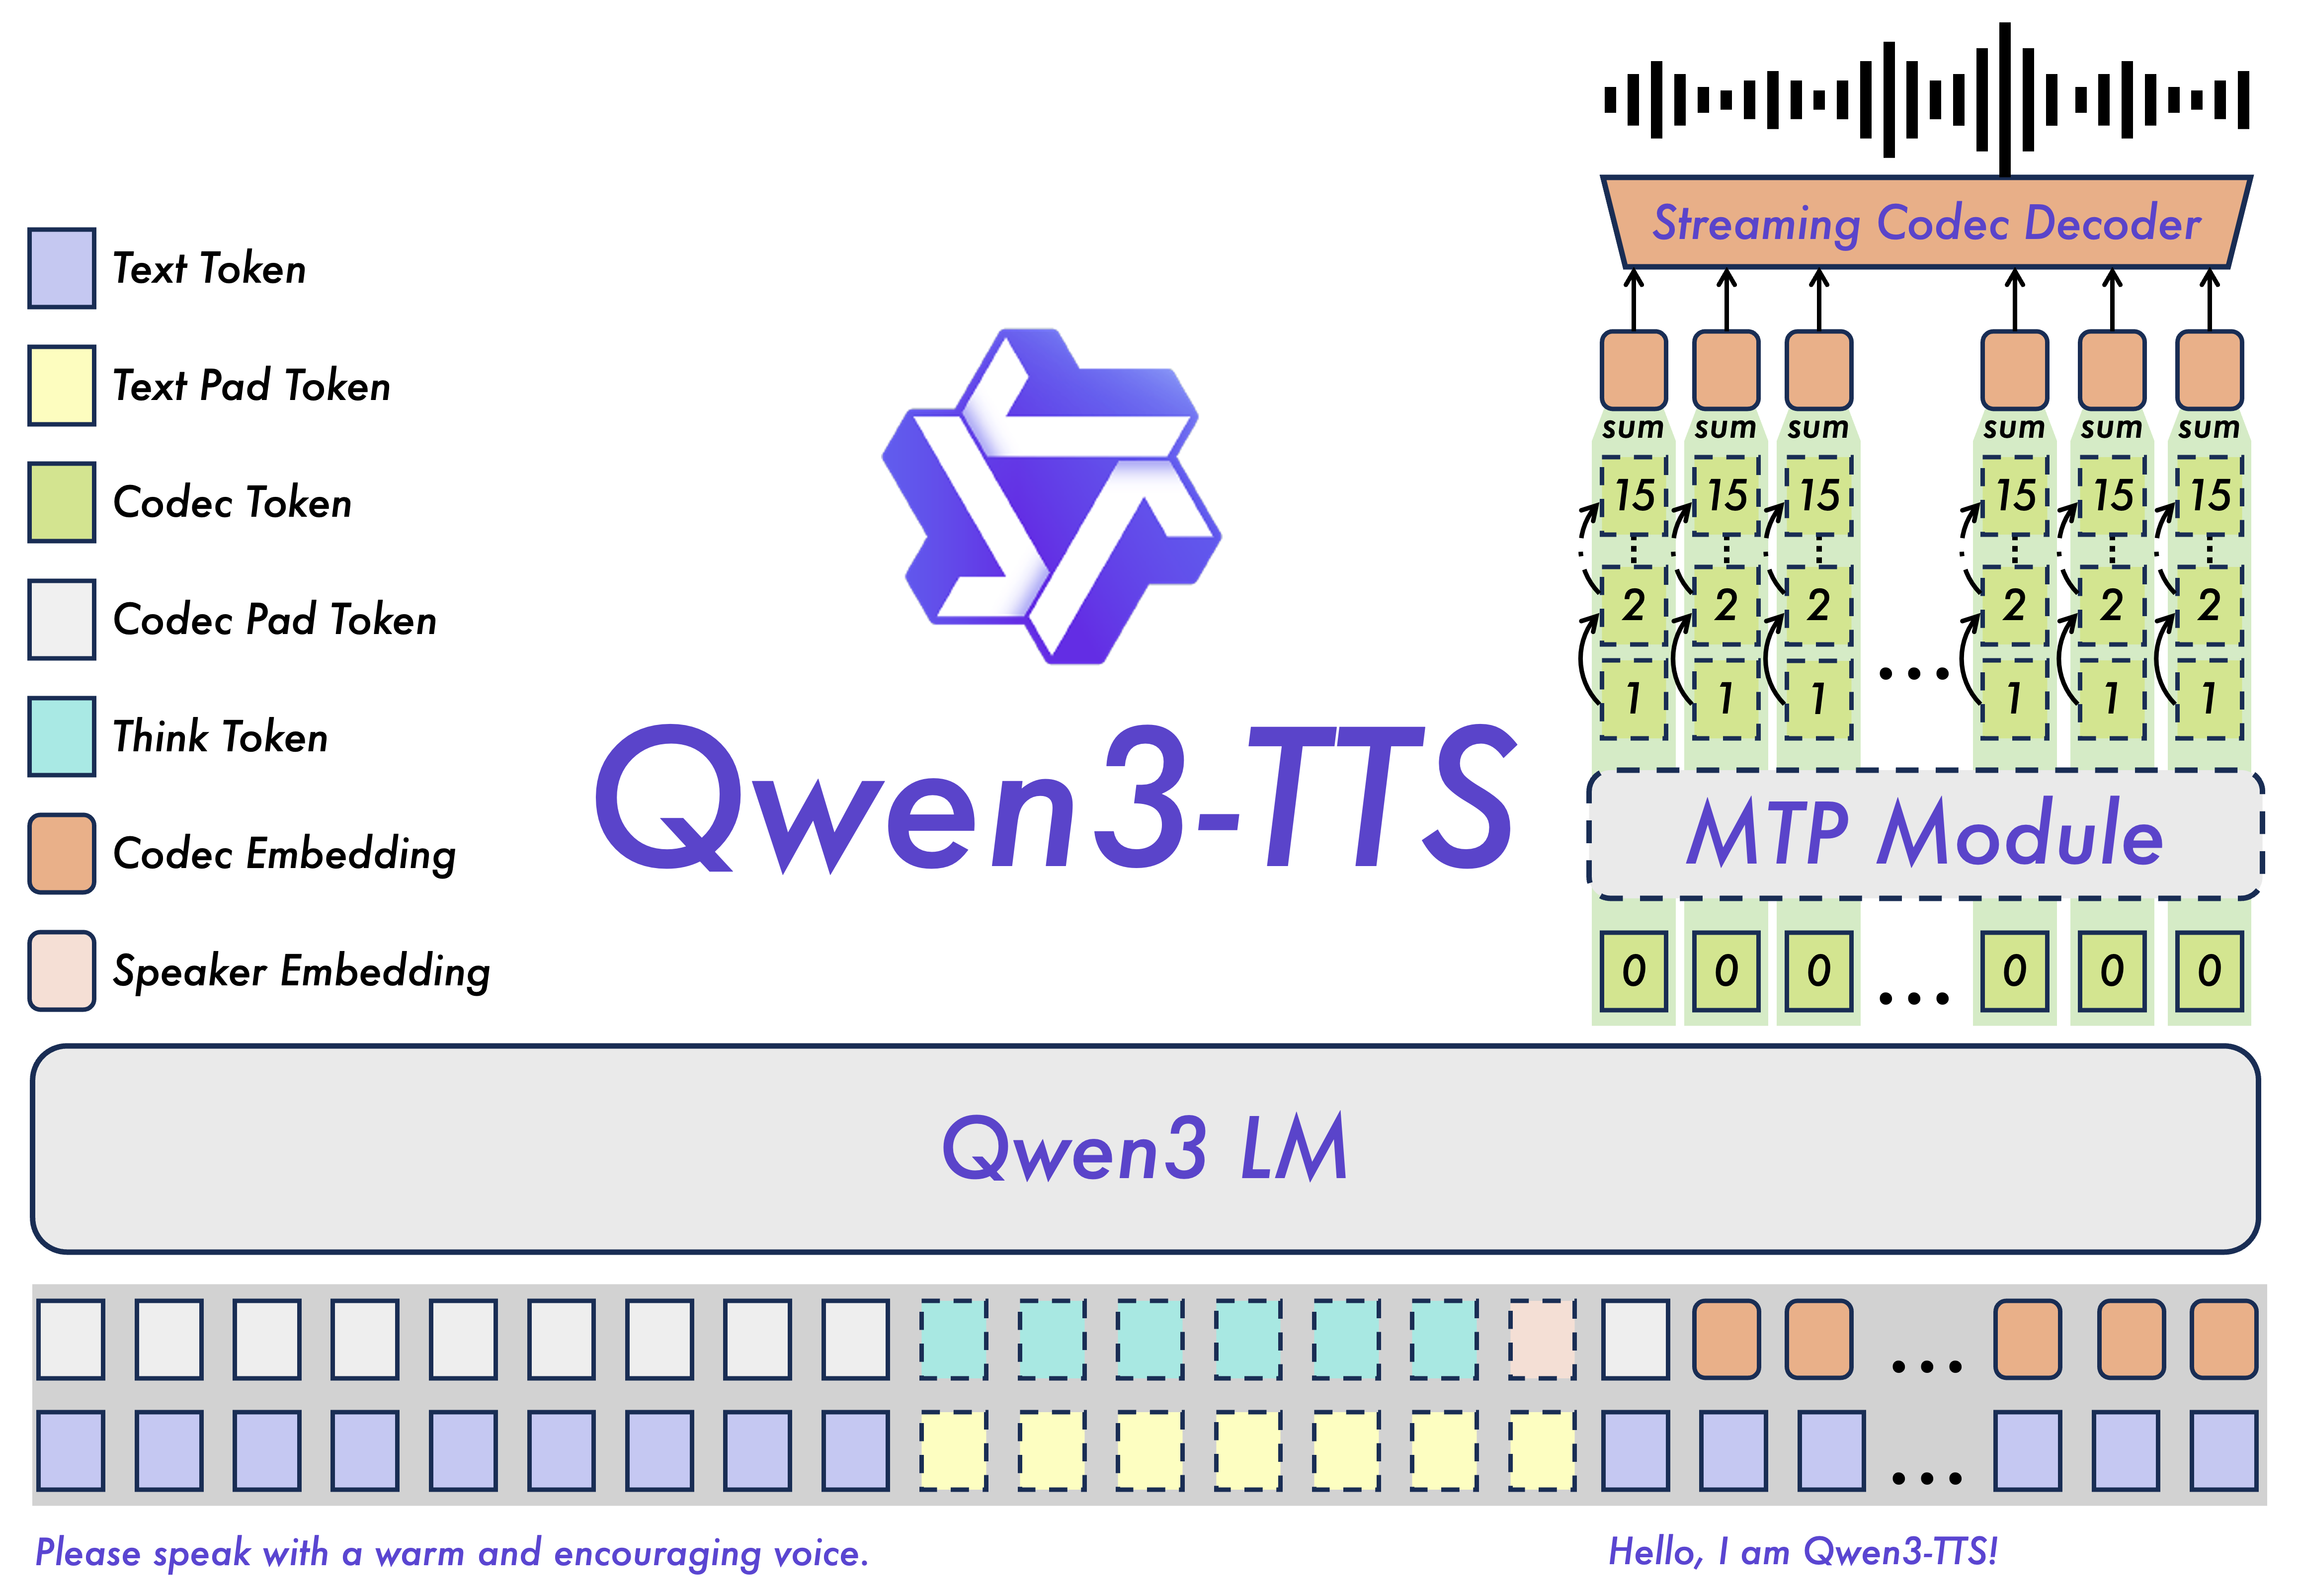

In [ ]:
import torch
import soundfile as sf
from qwen_tts import Qwen3TTSModel

# Load the model
model = Qwen3TTSModel.from_pretrained(
    "Qwen/Qwen3-TTS-12Hz-0.6B-Base",
    device_map="cuda:0",
    dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
)

# Reference audio for cloning
ref_audio = "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen3-TTS-Repo/clone.wav"
ref_text  = "Okay. Yeah. I resent you. I love you. I respect you. But you know what? You blew it! And thanks to you."

# Generate speech
wavs, sr = model.generate_voice_clone(
    text="I am solving the equation: x = [-b ± √(b²-4ac)] / 2a? Nobody can — it's a disaster (◍•͈⌔•͈◍), very sad!",
    language="English",
    ref_audio=ref_audio,
    ref_text=ref_text,
)

# Save the resulting audio
sf.write("output_voice_clone.wav", wavs[0], sr)


## 4. Chroma

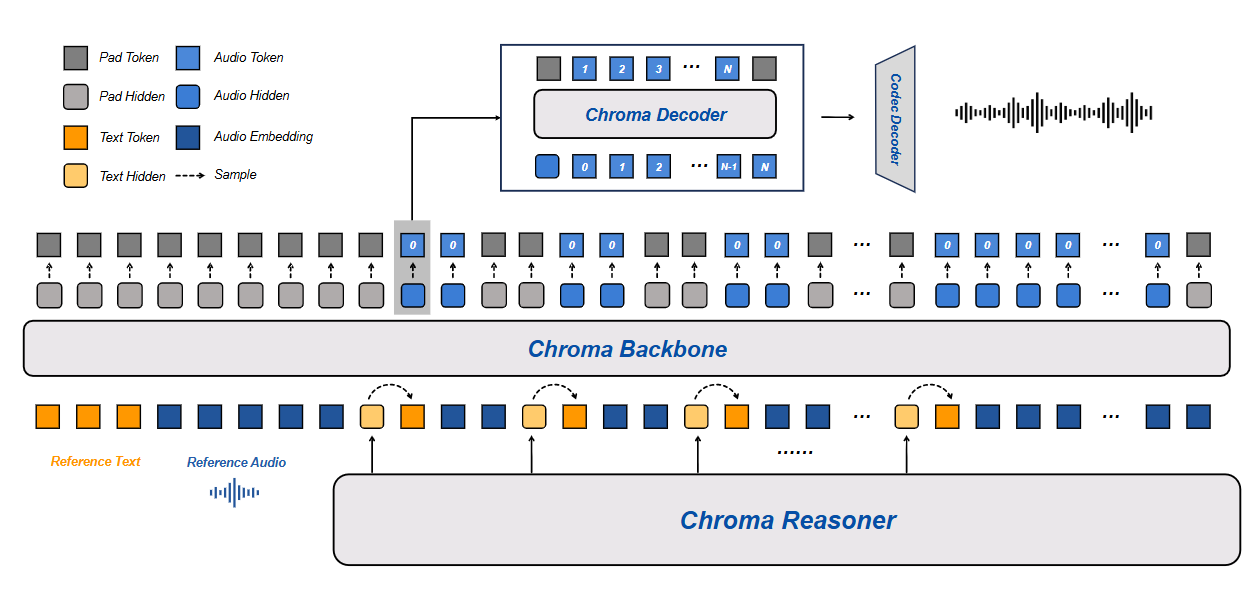

In [ ]:
from voicestudio.models.chroma import ChromaForConditionalGeneration

In [ ]:
model_id = "FlashLabs/Chroma-4B"

model = ChromaForConditionalGeneration.from_pretrained(model_id).to(device)
processor = AutoProcessor.from_pretrained(model_id)

In [ ]:
prompt = "Hey, how are you doing today?"
#description = "Jon's voice is monotone yet slightly fast in delivery, with a very close recording that almost has no background noise."
description = "A female speaker delivers a slightly expressive and animated speech with a moderate speed and pitch. The recording is of very high quality, with the speaker's voice sounding clear and very close up."

input_ids = tokenizer(description, return_tensors="pt").input_ids.to(device)
prompt_input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

audio_values = model.generate(input_ids=input_ids, prompt_input_ids=prompt_input_ids)
show_waveform(None, waveform=audio_values.cpu().squeeze(), sr=model.config.sampling_rate)

In [ ]:
# Construct conversation history
system_prompt = (
    "You are Chroma, an advanced virtual human created by the FlashLabs. "
    "You possess the ability to understand auditory inputs and generate both text and speech."
)
conversation = [[
    {
        "role": "system",
        "content": [
            {"type": "text", "text": system_prompt}
        ],
    },
    {
        "role": "user",
        "content": [
            # Input audio file path
            {"type": "audio", "audio": "assets/make_taco.wav"}, 
        ],
    },
]]

# Provide reference audio/text for style or context
prompt_text = ["War and bloodshed throughout the world."]
prompt_audio = ["assets/reference_audio.wav"]

# Process inputs
inputs = processor(
    conversation,
    add_generation_prompt=True, 
    tokenize=False,
    prompt_audio=prompt_audio,
    prompt_text=prompt_text
)

# Move inputs to device
device = model.device
inputs = {k: v.to(device) for k, v in inputs.items()}

# 2. Generate
output = model.generate(
    **inputs, 
    max_new_tokens=100, 
    do_sample=True,
    temperature=0.7,
    top_p=0.9,
    use_cache=True
)

# 3. Decode Audio
# The model outputs raw tokens; we decode the audio part using the codec
audio_values = model.codec_model.decode(output.permute(0, 2, 1)).audio_values

# Save or play audio (e.g., in Jupyter)
Audio(audio_values[0].cpu().detach().numpy(), rate=24_000)


## 5. Spark TTS

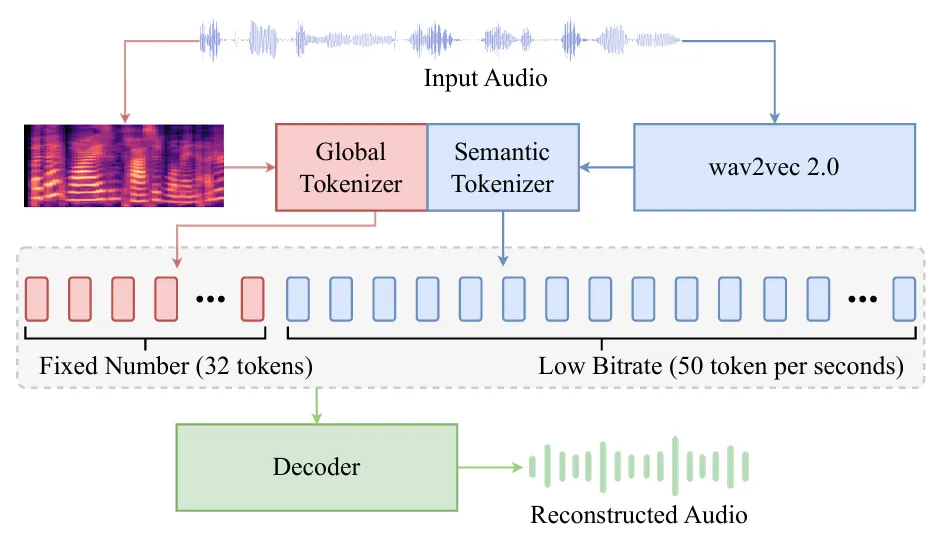
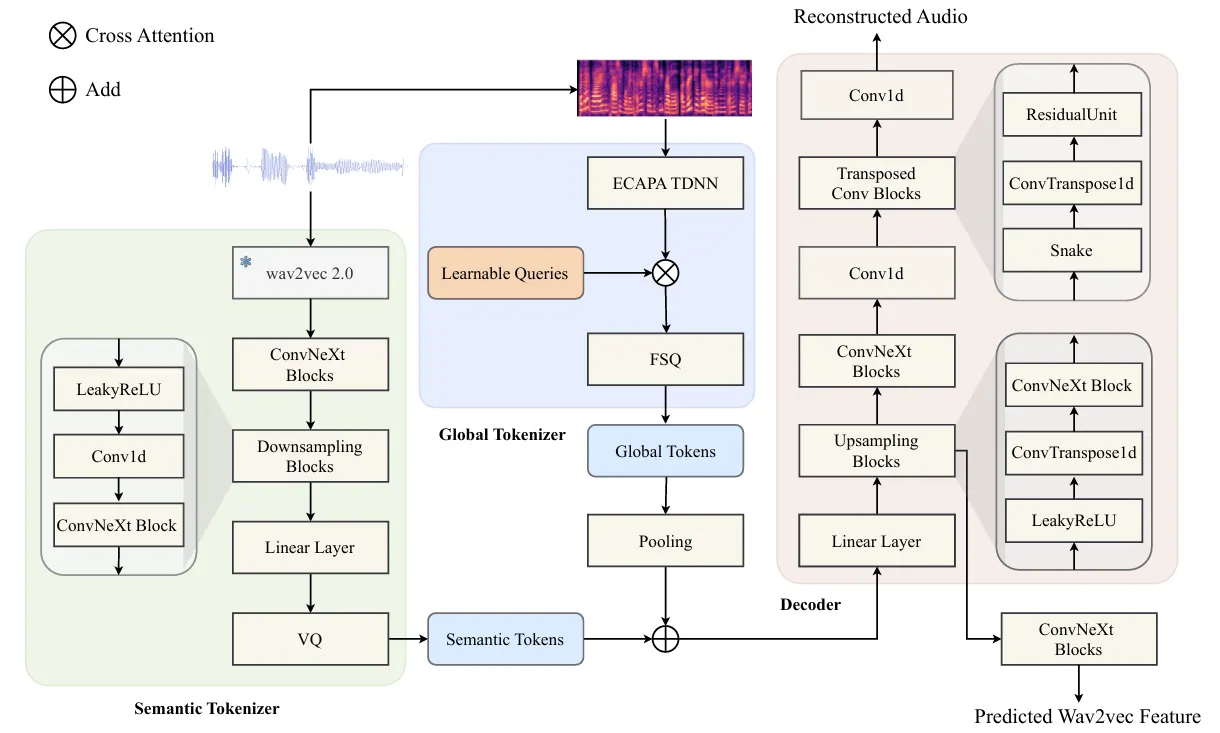
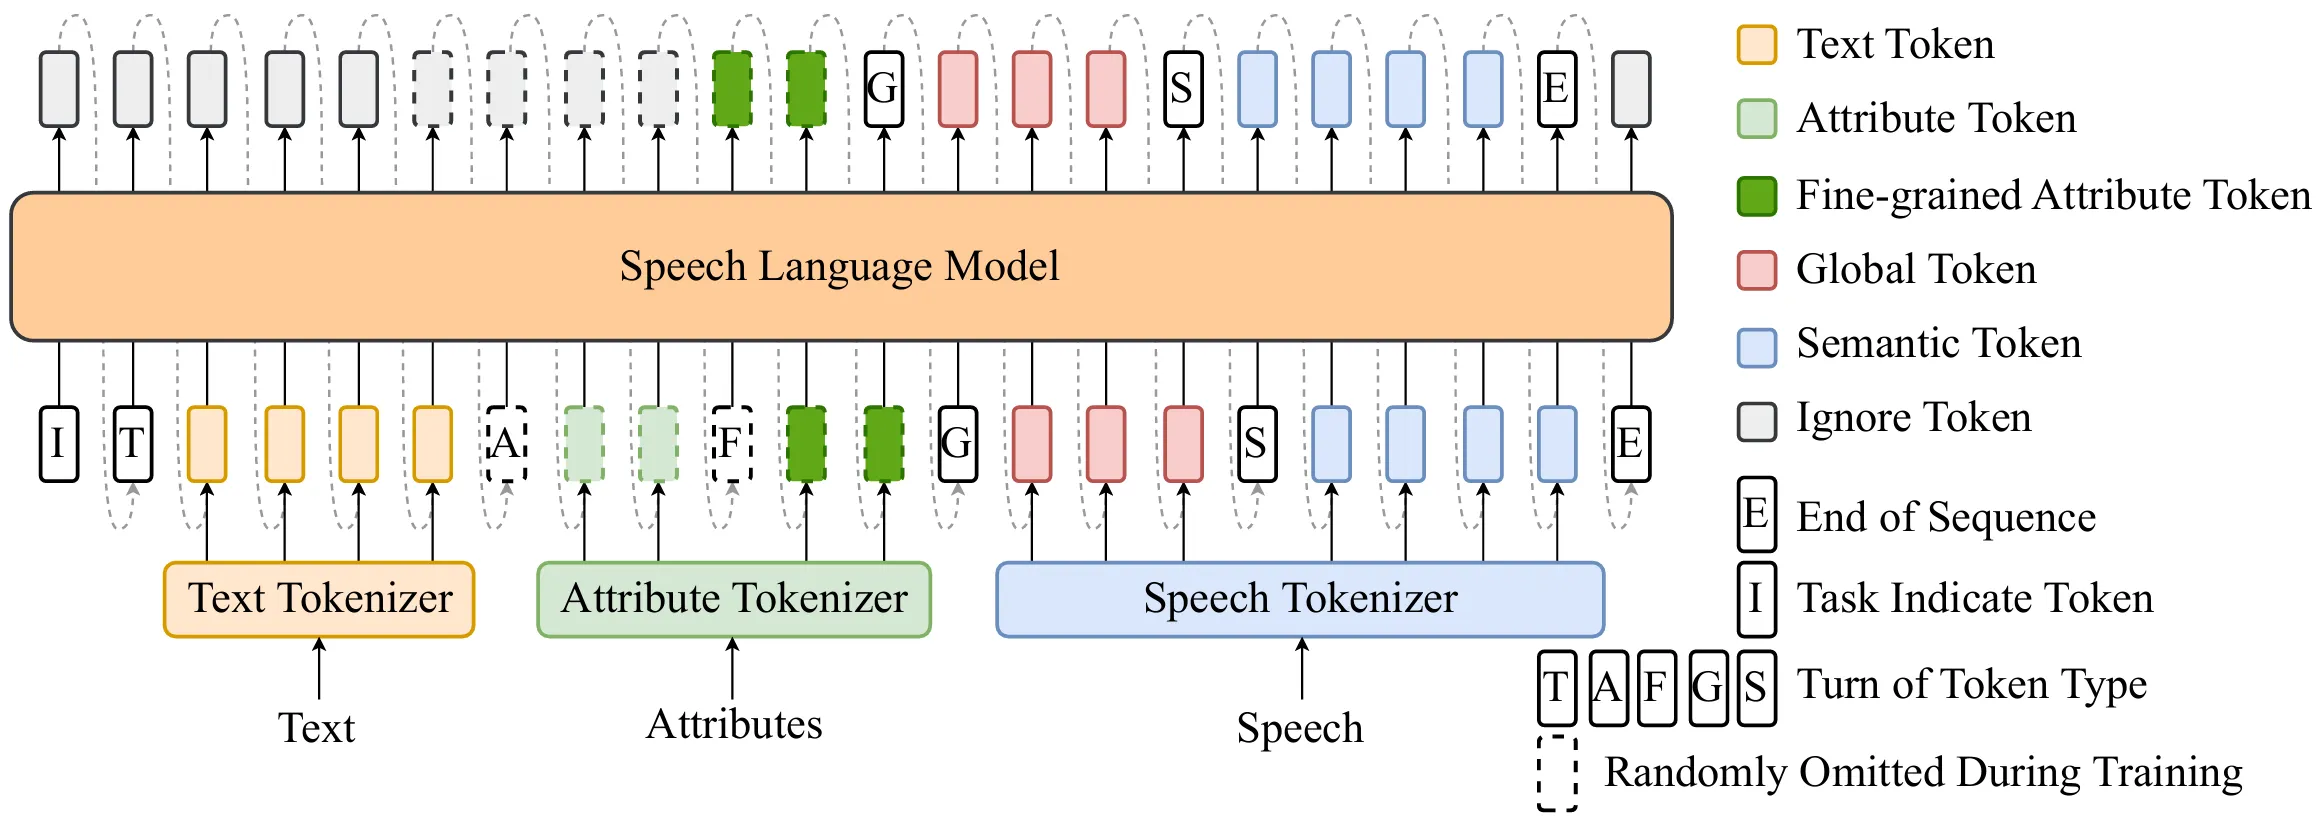

## 6. Dia 1

In [ ]:
from voicestudio.models.dia import DiaForConditionalGeneration

In [ ]:
model_id = "nari-labs/Dia-1.6B-0626"

model = DiaForConditionalGeneration.from_pretrained(model_id).to(device)
processor = AutoProcessor.from_pretrained(model_id)

In [ ]:
text = ["[S1] Dia is an open weights text to dialogue model."]
inputs = processor(text=text, padding=True, return_tensors="pt").to(device)

outputs = model.generate(**inputs, max_new_tokens=256)

# save audio to a file
outputs = processor.batch_decode(outputs)
processor.save_audio(outputs, "example.wav")

In [ ]:
# text is a transcript of the audio + additional text you want as new audio
text = ["[S1] I know. It's going to save me a lot of money, I hope. [S2] I sure hope so for you."]

inputs = processor(text=text, audio=audio, padding=True, return_tensors="pt").to(device)
prompt_len = processor.get_audio_prompt_len(inputs["decoder_attention_mask"])

# retrieve actually generated audio and save to a file
outputs = processor.batch_decode(outputs, audio_prompt_len=prompt_len)
processor.save_audio(outputs, "example_with_audio.wav")

## 7. CosyVoice 1/2/3

## 8. F5 TTS